In [1]:
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, List, Literal, Sequence, Tuple
from moseq2_detectron_extract.proc.roi import get_bbox_size
from moseq2_detectron_extract.io.annot import register_dataset_metadata
register_dataset_metadata('moseq')

In [2]:
h5_path = r"E:\moseq_raw_data\detectron2_testing_full\session_20200915132521_top-score-vote\results_00.h5"
h5_file = h5py.File(h5_path)

In [3]:
clean_frames = h5_file['/frames'][()]
angles = h5_file['/scalars/angle'][()]
centroids = np.stack((
    h5_file['/scalars/centroid_x_px'][()],
    h5_file['/scalars/centroid_y_px'][()]
), axis=1)
roi = h5_file['/metadata/extraction/roi'][()]
print(clean_frames.shape)
print(angles.shape)
print(centroids.shape)
print(roi.shape)

(1000, 80, 80)
(1000,)
(1000, 2)
(424, 512)


In [4]:
def reverse_crop_and_rotate_frame(frame: np.ndarray, dest_size: Tuple[int, int], center: Tuple[float, float], angle: float):

    if np.isnan(angle) or np.any(np.isnan(center)):
        return np.zeros_like(frame, shape=dest_size) # pylint: disable=unexpected-keyword-arg

    frame = frame.copy()
    src_shape = frame.shape
    src_center = (src_shape[0] // 2, src_shape[1] // 2)

    rot_mat = cv2.getRotationMatrix2D(src_center, -angle, 1)
    frame = cv2.warpAffine(frame, rot_mat, (dest_size[0], dest_size[1]))

    translate_mat = np.float32([
        [1, 0, center[0] - src_center[0]],
        [0, 1, center[1] - src_center[1]]
    ])
    frame = cv2.warpAffine(frame, translate_mat, (dest_size[0], dest_size[1]))

    return frame

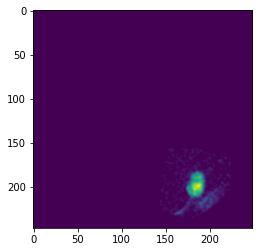

In [5]:
i = 840

dest_size = get_bbox_size(roi)
frame = reverse_crop_and_rotate_frame(clean_frames[i], dest_size, centroids[i], angles[i])
plt.imshow(frame)

In [6]:
from moseq2_detectron_extract.io.flips import preview_video_from_h5
preview_video_from_h5(h5_file, r'E:\moseq_raw_data\detectron2_testing_full\session_20200915132521_top-score-vote\results_00.fromh5.mp4')

batches: 100%|██████████| 100/100 [13:36<00:00,  8.16s/it]
